In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch

from raytracerthing import RayTracerThing, Activations

np.random.seed(42)

In [2]:
digits = load_digits()
digits.keys()

y = digits['target']

X = digits['images']
X = X[y < 2]
X = X / X.max()
N = X.shape[0]
image_shape = X.shape[1:]

print(N, image_shape)

y = y[y < 2]

print(y[:5])

360 (8, 8)
[0 1 0 1 0]


In [3]:
np.unique(y, return_counts=True)

(array([0, 1]), array([178, 182]))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
%%time

clf = RayTracerThing(input_shape=image_shape,
                     n_layers=3,
                     n_classes=2,
                     activation_func=lambda x: Activations.sigmoid(x, alpha=10),
                     loss_func=torch.nn.functional.binary_cross_entropy,
                     learning_rate=1)

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 32.4 ms


In [6]:
%time clf.fit(X_train, y_train, batch_size=32, n_epochs=1000)

Epoch 1 of 1000 - train_loss: 1.2403 - train_acc: 0.6953 - val_loss: 0.3617 - val_acc: 0.8276
Epoch 2 of 1000 - train_loss: 0.2120 - train_acc: 0.9297 - val_loss: 0.2564 - val_acc: 0.9138
Epoch 3 of 1000 - train_loss: 0.1739 - train_acc: 0.9531 - val_loss: 0.2379 - val_acc: 0.9310
Epoch 4 of 1000 - train_loss: 0.1604 - train_acc: 0.9609 - val_loss: 0.2265 - val_acc: 0.9310
Epoch 5 of 1000 - train_loss: 0.1507 - train_acc: 0.9688 - val_loss: 0.2162 - val_acc: 0.9310
Epoch 6 of 1000 - train_loss: 0.1418 - train_acc: 0.9805 - val_loss: 0.2066 - val_acc: 0.9310
Epoch 7 of 1000 - train_loss: 0.1343 - train_acc: 0.9805 - val_loss: 0.1997 - val_acc: 0.9310
Epoch 8 of 1000 - train_loss: 0.1289 - train_acc: 0.9805 - val_loss: 0.1941 - val_acc: 0.9310
Epoch 9 of 1000 - train_loss: 0.1241 - train_acc: 0.9805 - val_loss: 0.1900 - val_acc: 0.9310
Epoch 10 of 1000 - train_loss: 0.1214 - train_acc: 0.9805 - val_loss: 0.1884 - val_acc: 0.9310
Epoch 11 of 1000 - train_loss: 0.1198 - train_acc: 0.9805 -

Epoch 87 of 1000 - train_loss: 0.0887 - train_acc: 0.9805 - val_loss: 0.1426 - val_acc: 0.9483
Epoch 88 of 1000 - train_loss: 0.0887 - train_acc: 0.9805 - val_loss: 0.1425 - val_acc: 0.9655
Epoch 89 of 1000 - train_loss: 0.0886 - train_acc: 0.9805 - val_loss: 0.1424 - val_acc: 0.9655
Epoch 90 of 1000 - train_loss: 0.0886 - train_acc: 0.9805 - val_loss: 0.1422 - val_acc: 0.9655
Epoch 91 of 1000 - train_loss: 0.0886 - train_acc: 0.9805 - val_loss: 0.1421 - val_acc: 0.9655
Epoch 92 of 1000 - train_loss: 0.0885 - train_acc: 0.9805 - val_loss: 0.1420 - val_acc: 0.9655
Epoch 93 of 1000 - train_loss: 0.0885 - train_acc: 0.9805 - val_loss: 0.1418 - val_acc: 0.9655
Epoch 94 of 1000 - train_loss: 0.0884 - train_acc: 0.9805 - val_loss: 0.1417 - val_acc: 0.9655
Epoch 95 of 1000 - train_loss: 0.0884 - train_acc: 0.9805 - val_loss: 0.1416 - val_acc: 0.9655
Epoch 96 of 1000 - train_loss: 0.0884 - train_acc: 0.9805 - val_loss: 0.1415 - val_acc: 0.9655
Epoch 97 of 1000 - train_loss: 0.0883 - train_acc:

Epoch 172 of 1000 - train_loss: 0.0858 - train_acc: 0.9805 - val_loss: 0.1409 - val_acc: 0.9655
Epoch 173 of 1000 - train_loss: 0.0858 - train_acc: 0.9805 - val_loss: 0.1409 - val_acc: 0.9655
Epoch 174 of 1000 - train_loss: 0.0858 - train_acc: 0.9805 - val_loss: 0.1409 - val_acc: 0.9655
Epoch 175 of 1000 - train_loss: 0.0858 - train_acc: 0.9805 - val_loss: 0.1409 - val_acc: 0.9655

Stopping early.

CPU times: user 10.9 s, sys: 344 ms, total: 11.2 s
Wall time: 11 s


In [7]:
y_pred = clf.predict(X_test)

In [8]:
clf.score(X_test, y_test)

tensor(0.9861)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99        35
          1       1.00      0.97      0.99        37

avg / total       0.99      0.99      0.99        72



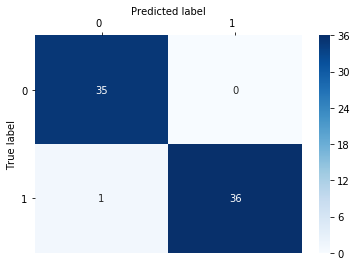

In [10]:
cm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

cm.yaxis.set_ticklabels(cm.yaxis.get_ticklabels(), rotation=0, ha='right')
cm.xaxis.set_ticklabels(cm.xaxis.get_ticklabels(), rotation=0, ha='right')
cm.xaxis.tick_top()
cm.xaxis.set_label_position('top')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

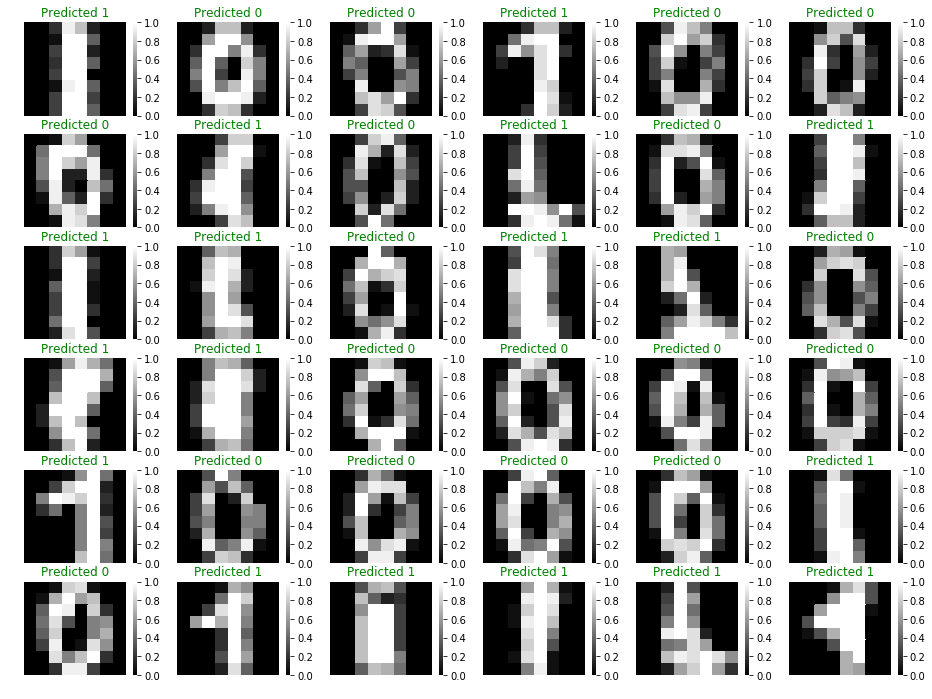

In [11]:
n_rows = 6
n_cols = 6
n_total = n_rows * n_cols
n_total = min(n_total, N)

width_ratio = 2.7
height_ratio = 2

figsize = (int(width_ratio * n_cols), int(height_ratio * n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.ravel()

for ax, image, expected, actual in zip(axes, X_test[:n_total], y_test[:n_total], y_pred[:n_total]):
    sns.heatmap(image, vmin=0.0, vmax=1.0, cmap='gray', ax=ax)
    ax.set_axis_off()

    color = 'green' if expected == actual else 'red'
    ax.set_title('Predicted %d' % actual, color=color)

plt.show()

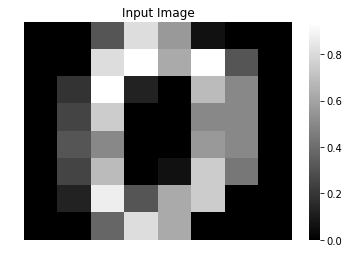

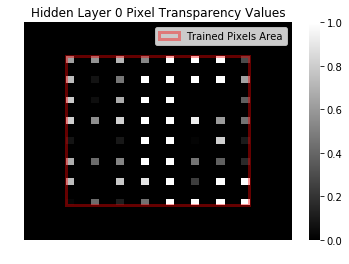

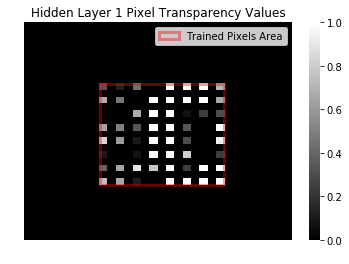

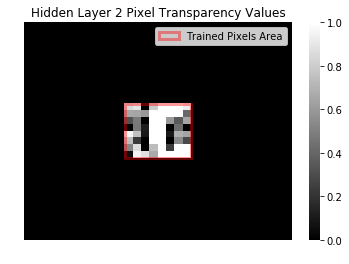

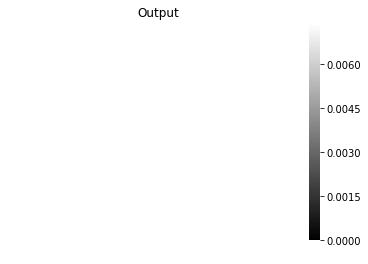

In [13]:
ax = sns.heatmap(X[0], cmap='gray')
ax.set(title='Input Image')
ax.set_axis_off()
plt.show()

for i, layer in enumerate(clf.hidden_layers):              
    ax = sns.heatmap(layer.pixel_values, vmin=0, vmax=1, cmap='gray')
    trained_pixels = clf.grid_W_map[i].keys() 

    min_extent = clf.layer_shape
    max_extent = (0, 0)

    for grid_coord in trained_pixels:
        grid_row, grid_col = grid_coord

        if grid_row < min_extent[0]:
            min_extent = (grid_row, min_extent[1])

        if grid_row > max_extent[0]:
            max_extent = (grid_row, max_extent[1])

        if grid_col < min_extent[1]:
            min_extent = (min_extent[0], grid_col)

        if grid_col > max_extent[1]:
            max_extent = (max_extent[0], grid_col)

    height = (max_extent[0] - min_extent[0]) + 0.9
    width = (max_extent[1] - min_extent[1]) + 0.9

    rect = patches.Rectangle((min_extent[1], min_extent[0]), width, height, 
                             linewidth=3, alpha=0.4, 
                             edgecolor='r', facecolor='none',
                             label='Trained Pixels Area')

    ax.add_patch(rect)

    ax.set_axis_off()
    ax.set(title='Hidden Layer %d Pixel Transparency Values' % i)
    ax.legend()
    plt.show()
        
ax = sns.heatmap(clf.predict_proba(X).detach().numpy()[0].reshape(1, -1), vmin=0, cmap='gray')
ax.set(title='Output')
ax.set_axis_off()
plt.show()